<a href="https://colab.research.google.com/github/Jathurshan0330/BRATS-Brain-Tumor-Segmentation/blob/master/170248G_BM4301_Brain_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Get Requirements

In [7]:
from IPython.display import clear_output

In [8]:
!pip install itk itkwidgets ipywidgets
clear_output()

In [9]:
#Import Libraries
import itk
import numpy as np
import nibabel as nib
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

#Load Data

In [11]:
base = '/content/drive/MyDrive/brats2018/Brats18_2013_10_1_'

flair_fn = base + 'flair.nii'
t1_fn = base + 't1.nii'
t1ce_fn = base + 't1ce.nii'
t2_fn = base + 't2.nii'
seg_fn = base + 'seg.nii'

flair = itk.imread(flair_fn)
t1 = itk.imread(t1_fn)
t1ce = itk.imread(t1ce_fn)
t2 = itk.imread(t2_fn)
seg = itk.imread(seg_fn)
print(flair.shape, t1.shape, t1ce.shape, t2.shape, seg.shape)

(155, 240, 240) (155, 240, 240) (155, 240, 240) (155, 240, 240) (155, 240, 240)


## Visulaization

(<matplotlib.image.AxesImage at 0x7f091136ae90>, Text(0.5, 1.0, 'seg'))

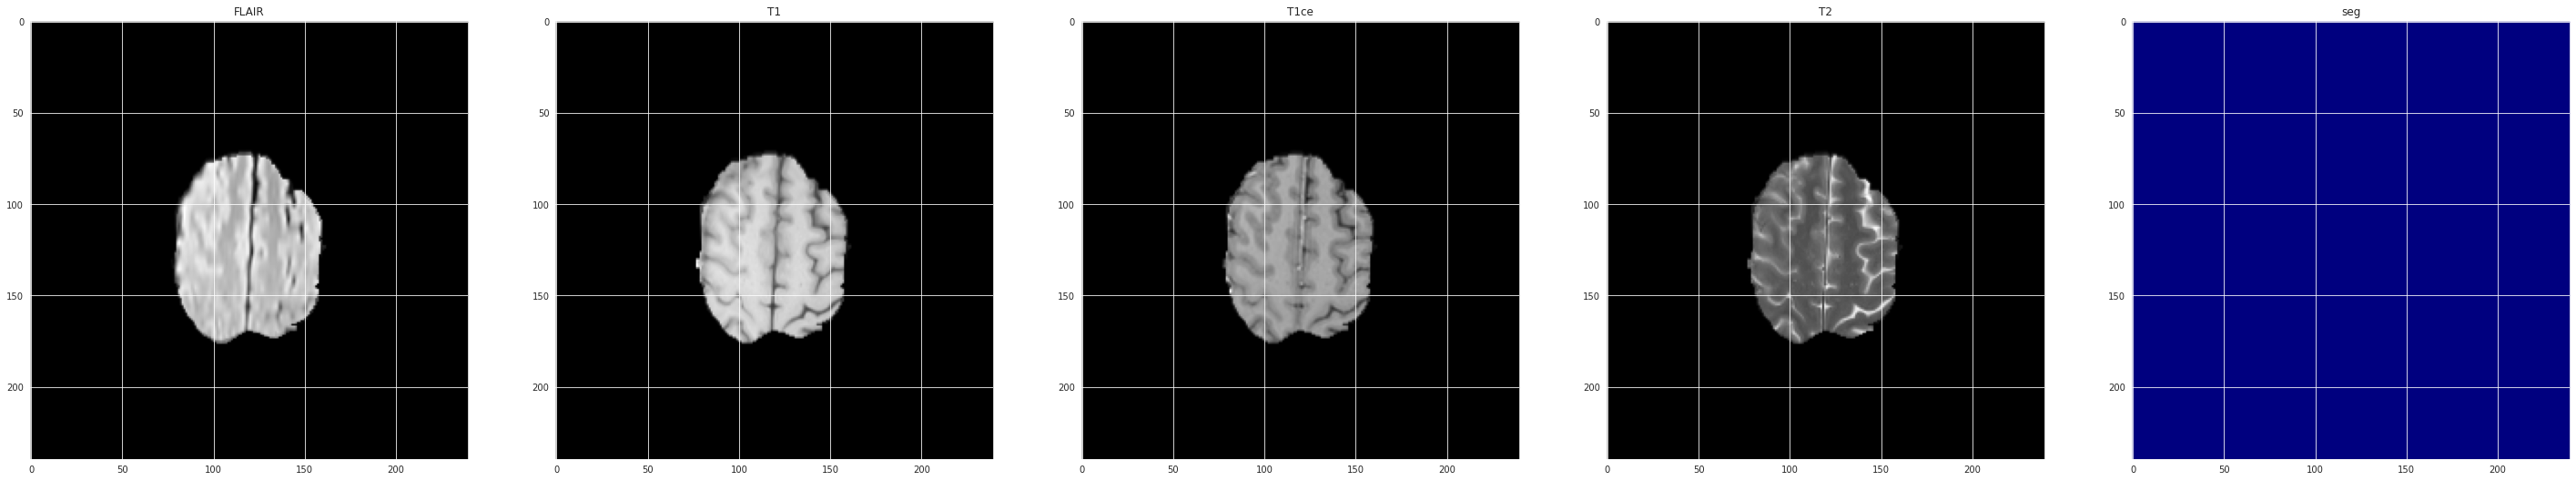

In [14]:
#Visualize images
slice = 125
fig, ax = plt.subplots(1,5, figsize=(50,10))
ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('FLAIR')
ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1')
ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce')
ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2')
ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('seg')

In [19]:
#Interactive visualization
# Create layer slider
select_slice = IntSlider(min=0, max=flair.shape[0]-1, description='Select Slice', continuous_update=False)

# Define a function for plotting images
def plot_image(slice):
    print(f"Plotting {slice} Slice")
    fig, ax = plt.subplots(1,5, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray'), ax[0].set_title('FLAIR')
    ax[1].imshow(t1[slice], cmap='gray'), ax[1].set_title('T1')
    ax[2].imshow(t1ce[slice], cmap='gray'), ax[2].set_title('T1ce')
    ax[3].imshow(t2[slice], cmap='gray'), ax[3].set_title('T2')
    ax[4].imshow(seg[slice], cmap='jet'), ax[4].set_title('seg')


# Use the interactive() tool to create the visualization
interactive(plot_image, slice=select_slice)
    

interactive(children=(IntSlider(value=0, continuous_update=False, description='Select Slice', max=154), Output…

# Segmentation using 5 algorithms in ITK